## Get the data

Importing useful dependencies

In [1]:
#numpyro is used for modeling and inference
!pip install pyro-ppl 
!pip install "jax[cpu]===0.3.14" -f https://whls.blob.core.windows.net/unstable/index.html --use-deprecated legacy-resolver
!pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.5/732.5 kB 11.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://whls.blob.core.windows.net/unstable/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.1/990.1 kB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 MB 12.4 MB/s eta 0:00:00
  Created wheel for jax: filename=jax-0.3.14-py3-none-any.whl size=1147569 sha256=a2077e41417e0ad0eeb5c6b9538071fa155e3f3da98974cf6691493230b9e8d6
  Stored in directory: /root/.cache/pip/wheels/cc/b2/fd/3e8a8312ad916a677b3beb844bfba172999a08244fb1395149
Successfully built jax
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-

In [4]:
# Run this cell if you haven't installed pandas-profiling in your computer
# !pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.6/22.6 MB 33.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.4/455.4 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 26.2 MB/s eta 0:00:00
  Created wheel for ydata-profiling: filename=ydata_profiling-0.0.dev0-py2.py3-none-any.whl size=352322 sha256=2501904f9bf38fd01bd94e73a1850d8b4c1e7df31afee469e5f438d8a87212e8
  Stored in directory: /tmp/pip-ephem-wheel-cache-5t903k8i/wheels/07/29/61/f533cc7cbd0a97efb2d1b94d3254a3e859a949367ba842577b
  Created wheel for htmlmin: file

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # not sure if this is needed
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from pandas_profiling import ProfileReport

from scipy.stats import zscore
import torch

# NumPyro-specific imports
import numpyro
import jax.numpy as jnp
from jax import random
from numpyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from numpyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from numpyro.optim import Adam, ClippedAdam
from numpyro.distributions import TruncatedNormal, Gamma # easier to use, when they are imported already

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

# For scaling
scaler = StandardScaler()

<ipython-input-5-886c6bfe0676>:11: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


##Load Data

**The process below shows the way we merged the initial .parquet files for both January and August 2022, in order to create a .csv file. This .csv file contains the data that we'are using throughout the notebook (before the preprocessing). The cells with the process are commented out, but feel free to uncomment it and run it to your system, if you are up to. Just select the whole content of each cell with (Ctrl + A) and uncomment it by pressing (Ctrl + /)**

**Otherwise, you can just use directly the data_processed.csv**

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# #Load data
# # For some reason, you have to upload the files manually - they will stay till you end the session :/
# # Define the directory where the parquet files are stored, this is the folder where all the dataset is located
# directory = '/content/drive/My Drive/Project MBML'

# # Get a list of all the parquet files in the directory
# parquet_files = ['/content/drive/My Drive/Project MBML/green_tripdata_2022-01.parquet', '/content/drive/My Drive/Project MBML/green_tripdata_2022-08.parquet', '/content/drive/My Drive/Project MBML/yellow_tripdata_2022-01.parquet', '/content/drive/My Drive/Project MBML/yellow_tripdata_2022-08.parquet']

# # make two dataframes because the columns for pickup and dropoff time have different names
# df1 = pd.concat([pd.read_parquet(f) for f in parquet_files[:2]], ignore_index=True)
# df1 = df1.drop(['VendorID', 'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID', 'fare_amount', 'extra', 'mta_tax', 'tolls_amount', 'ehail_fee', 'improvement_surcharge', 'trip_type', 'congestion_surcharge'], axis=1)
# df2 = pd.concat([pd.read_parquet(f) for f in parquet_files[2:]], ignore_index=True)
# df2 = df2.drop(['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'fare_amount', 'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'airport_fee'], axis=1)
# # make sure column names are the same
# df2['lpep_pickup_datetime'] = df2['tpep_pickup_datetime']
# df2['lpep_dropoff_datetime'] = df2['tpep_dropoff_datetime']
# df2 = df2.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

# df2 = df2[['lpep_pickup_datetime', 'lpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'tip_amount', 'total_amount', 'payment_type']]

# # merge the dataframes and the columsn with different names
# df = pd.concat([df1, df2], ignore_index=True)

##Data Preparation

This is a function, that will help later on

In [9]:
# # Define a function to categorize the timestamp
# def categorize_time(hour):
#     return hour // 1

Doing some datapreparation

In [10]:
# # add trip duration
# # Substracts pickup and dropoff dates from each other and create a new coloumn with the trip_duration as result 
# df['trip_duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
# df['trip_duration'] = df['trip_duration'].astype('timedelta64[s]')

In [11]:
# # Remove duplicates
# df = df.drop_duplicates()

# # remove missing data
# df.dropna()

# # get tip out of total amount
# df['total_amount'] = df['total_amount'] - df['tip_amount']

# # remove negative/unreasonable values
# df = df[df.passenger_count >= 1]
# df = df[df.trip_distance > 0]
# df = df[df.tip_amount >= 0]
# df = df[df.total_amount > 0]
# df = df[df.trip_duration > 0]


# # remove not card payment
# df = df[df.payment_type == 1]
# df = df.drop(['payment_type'], axis=1)

In [12]:
# features_outliers = df[['trip_distance', 'tip_amount', 'total_amount', 'trip_duration']]

# # Counter for how many outliers have been removed
# num_outliers_removed = 0
# for feature in features_outliers:
#     # Extract the values of the feature
#     values = df[feature]

#     #Calculate the standard deviation for the feature
#     sigma = np.std(values)
#     mu = np.mean(values)

#     lower_bound = mu - 3 * sigma
#     upper_bound = mu + 3 * sigma
    
#     # Remove outliers from the feature in the existing DataFrame
#     removed_rows = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)] # just for counting numbers of outliers
#     df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)].reset_index(drop=True)

#     # Numbers of outliers removed from each feature
#     num_outliers_removed += len(removed_rows)

# print(f'Number of outliers removed: {num_outliers_removed}')

Number of outliers removed: 224164


In [13]:
# # Create new coloumn with dates as weekday - 
# # monday = 0, tuesday=1, wednesday=2, thursday=3, friday=4, saturday=5, sunday=6
# df['weekday'] = df['lpep_pickup_datetime'].dt.weekday

# # Create a new column with the categorized time
# df['time_category'] = df['lpep_pickup_datetime'].dt.hour.apply(categorize_time)
# df['time_category'] = df['time_category'].astype('category').cat.codes

# df = df.drop(['lpep_pickup_datetime', 'lpep_dropoff_datetime'], axis=1)

Lets see the data after outliers have been removed and the data preparation is done

In [14]:
# df.to_csv(directory+'/data_processed.csv')

## Exploratory Data Analysis

In [ ]:
df = pd.read_csv('data_processed.csv')

Here, we will calculate some basic statistics of our dataframe. At the same time, we will create some visualizations, to get a better overview of our final dataset, before moving to the modeling part.

In [15]:
df.describe()

passenger_count  trip_distance    tip_amount  total_amount  \
count     3.945447e+06   3.945447e+06  3.945447e+06  3.945447e+06   
mean      1.414179e+00   2.643482e+00  2.779994e+00  1.523535e+01   
std       9.581755e-01   2.579723e+00  1.770538e+00  7.836459e+00   
min       1.000000e+00   1.000000e-02  0.000000e+00  3.000000e-01   
25%       1.000000e+00   1.110000e+00  1.850000e+00  1.030000e+01   
50%       1.000000e+00   1.800000e+00  2.360000e+00  1.280000e+01   
75%       1.000000e+00   3.040000e+00  3.320000e+00  1.730000e+01   
max       7.000000e+00   2.141000e+02  1.234000e+01  5.030000e+01   

       trip_duration       weekday  time_category  
count   3.945447e+06  3.945447e+06   3.945447e+06  
mean    7.588611e+02  2.876955e+00   1.424231e+01  
std     4.830227e+02  1.960690e+00   5.687191e+00  
min     1.000000e+00  0.000000e+00   0.000000e+00  
25%     4.120000e+02  1.000000e+00   1.100000e+01  
50%     6.450000e+02  3.000000e+00   1.500000e+01  
75%     9.850000e+02  5.000000e+00   1.900000e+01  
max     8.735000e+03  6.000000e+00   2.300000e+01

Scatterplot between the trip distance and tip amount. Since the dataset is quite large, only a sample of 1000 instances will be selected

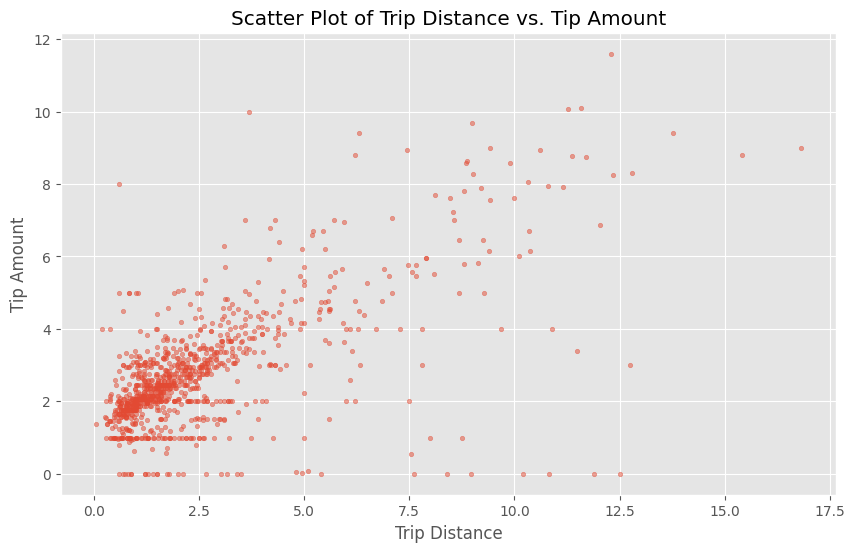

In [16]:
# Desired sample of the dataset
sample_size = 1000

# Scatterplot of trip distance vs tip amount
sampled_df = df.sample(n=sample_size)
trip_distance = sampled_df['trip_distance']
tip_amount = sampled_df['tip_amount']

plt.figure(figsize=(10, 6))
plt.scatter(trip_distance, tip_amount, alpha=0.5, s=10)
plt.xlabel('Trip Distance')
plt.ylabel('Tip Amount')
plt.title('Scatter Plot of Trip Distance vs. Tip Amount')
plt.show()

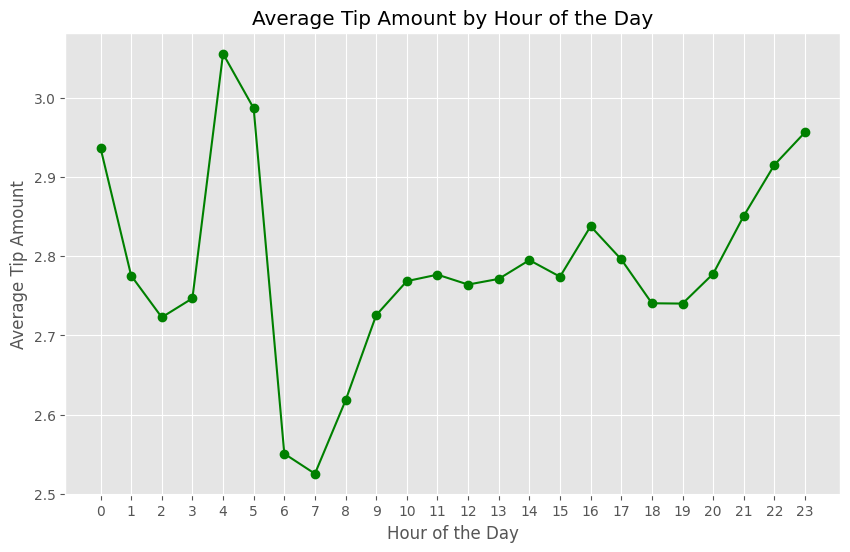

In [17]:
# lineplot of the average tip amount by hour of the day

average_tip_by_hour = df.groupby('time_category')['tip_amount'].mean()

plt.figure(figsize=(10, 6))
average_tip_by_hour.plot(kind='line', marker='o', color='green')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Tip Amount')
plt.title('Average Tip Amount by Hour of the Day')
plt.xticks(range(24))
plt.grid(True)
plt.show()

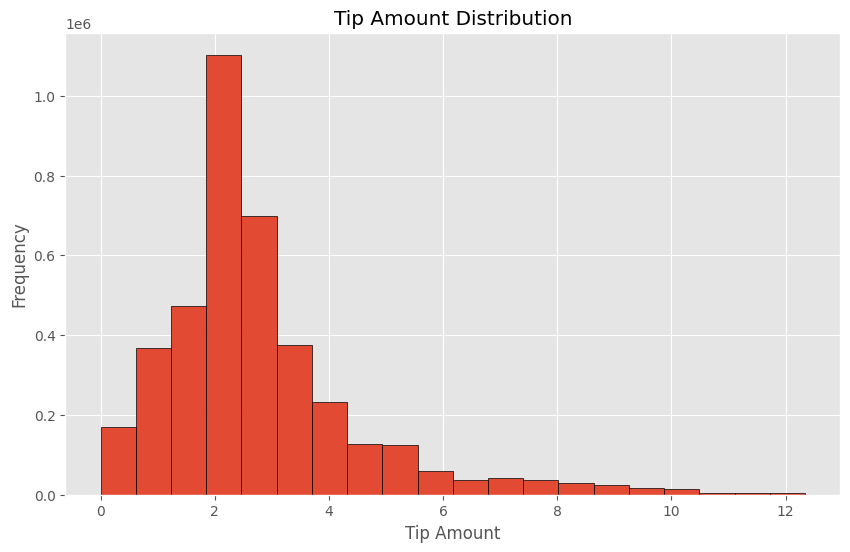

In [18]:
# distribution of tip amunt

tip_amount = df['tip_amount']

plt.figure(figsize=(10, 6))
plt.hist(tip_amount, bins=20, edgecolor='black')
plt.xlabel('Tip Amount')
plt.ylabel('Frequency')
plt.title('Tip Amount Distribution')
plt.show()


### Some extra stats

In [19]:
profile = ProfileReport(df, title="Denmark Electricity prices and other values", html={'style': {'full_width': True}})

In [20]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Final Preparation before Modelling

---



In [21]:
# Ensure float with 2 decimal - removing the science from the numbers, this is easier to look at
pd.options.display.float_format = '{:.2f}'.format

In [22]:
# prepare matrix with time features
#each line has a "1" for one weekday and one time category
X_day_time = np.concatenate([pd.get_dummies(df[x]) for x in ["weekday", "time_category"]], axis=1)
print(X_day_time.shape)

(3945447, 31)


In [23]:
day_time_names = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'] + [str(k) for k in range(24)]

X_day_time = pd.DataFrame(data=X_day_time, columns=day_time_names)

In [24]:
X_day_time.head()

Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday  0  1  2  \
0       0        0          0         0       0         1       0  1  0  0   
1       0        0          0         0       0         1       0  1  0  0   
2       0        0          0         0       0         1       0  1  0  0   
3       0        0          0         0       1         0       0  0  0  0   
4       0        0          0         0       0         1       0  1  0  0   

   ...  14  15  16  17  18  19  20  21  22  23  
0  ...   0   0   0   0   0   0   0   0   0   0  
1  ...   0   0   0   0   0   0   0   0   0   0  
2  ...   0   0   0   0   0   0   0   0   0   0  
3  ...   0   0   0   0   0   0   0   0   0   1  
4  ...   0   0   0   0   0   0   0   0   0   0  

[5 rows x 31 columns]

In [25]:
df = pd.concat([df,X_day_time], axis=1)
df.head()

passenger_count  trip_distance  tip_amount  total_amount  trip_duration  \
0             1.00           3.70        4.60         18.55         972.00   
1             1.00           6.26        5.21         26.05        1262.00   
2             1.00           4.75        4.21         21.05        1104.00   
3             1.00           6.03        1.50         22.55         802.00   
4             1.00           0.70        1.45          5.80         165.00   

   weekday  time_category  Monday  Tuesday  Wednesday  ...  14  15  16  17  \
0        5              0       0        0          0  ...   0   0   0   0   
1        5              0       0        0          0  ...   0   0   0   0   
2        5              0       0        0          0  ...   0   0   0   0   
3        4             23       0        0          0  ...   0   0   0   0   
4        5              0       0        0          0  ...   0   0   0   0   

   18  19  20  21  22  23  
0   0   0   0   0   0   0  
1   0   0   0   0   0   0  
2   0   0   0   0   0   0  
3   0   0   0   0   0   1  
4   0   0   0   0   0   0  

[5 rows x 38 columns]

# Selection of explanatory variables

In [26]:
explanatory_variables = ['passenger_count','trip_distance','total_amount','tip_amount'] + day_time_names
df = df.loc[:,explanatory_variables]
df.head()

passenger_count  trip_distance  total_amount  tip_amount  Monday  Tuesday  \
0             1.00           3.70         18.55        4.60       0        0   
1             1.00           6.26         26.05        5.21       0        0   
2             1.00           4.75         21.05        4.21       0        0   
3             1.00           6.03         22.55        1.50       0        0   
4             1.00           0.70          5.80        1.45       0        0   

   Wednesday  Thursday  Friday  Saturday  ...  14  15  16  17  18  19  20  21  \
0          0         0       0         1  ...   0   0   0   0   0   0   0   0   
1          0         0       0         1  ...   0   0   0   0   0   0   0   0   
2          0         0       0         1  ...   0   0   0   0   0   0   0   0   
3          0         0       1         0  ...   0   0   0   0   0   0   0   0   
4          0         0       0         1  ...   0   0   0   0   0   0   0   0   

   22  23  
0   0   0  
1   0   0  
2   0   0  
3   0   1  
4   0   0  

[5 rows x 35 columns]

In [27]:
# Assign the feature 'tip-amouint' to y, and removing it from the df X - 'tip_amount' is the target
y = df['tip_amount']
X = df.drop('tip_amount', axis=1)

# Selection of explanatory variables

In [28]:
#Standardization of the inputs
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

In [29]:
print("y_mean =" + str(y.mean(axis=0)))
print("y_std =" + str(y.std(axis=0)))

y_mean =2.7799944138142023
y_std =1.770537661807804


In [30]:
#Standardization of the output
#y is not centered around zero because the likelihood will have a positive support
y_std = y.std(axis=0)
y = y / y_std

# Train set and test set

In [31]:
# Split the df into a train- and test set
train_perc = 0.66 # percentage of training data

N = len(X)

split_point = int(train_perc*N)
perm = np.random.permutation(N)
i_train = perm[:split_point]
i_test = perm[split_point:]

X_train = np.array(X.iloc[i_train,:])
X_test = np.array(X.iloc[i_test,:])
y_train = np.array(y.iloc[i_train])
y_test = np.array(y.iloc[i_test])

N_train = len(y_train)
N_test = len(y_test)

In [32]:
# Prepare data for Pyro model
train_size = 100000
test_size = 100000

X_train_small = X_train[:train_size,:]
y_train_small = y_train[:train_size]

X_test_small = X_test[:test_size,:]
y_test_small = y_test[:test_size]

# Model - numpyro

#### Let's crreate a model to perform exponential regression

In [33]:
def model_Expo(X, obs=None):
    alpha = numpyro.sample("alpha", numpyro.distributions.Normal(0., 3.))  # Prior for the bias/intercept
    beta  = numpyro.sample("beta", numpyro.distributions.Normal(jnp.zeros(X.shape[1]), 3*jnp.ones(X.shape[1])))  # Priors for the regression coeffcients

    with numpyro.plate("data", X.shape[0]):
        teta = jnp.exp(alpha + jnp.matmul(X, beta))
        y = numpyro.sample("y", numpyro.distributions.Exponential(teta), obs=obs)

    return y

# MCMC - numpyro

In [34]:
# Run inference in NumPyro

# Define key
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model = model_Expo)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=200, num_chains=1)
mcmc.run(rng_key, X_train_small, y_train_small)

# Show summary of inference results
mcmc.print_summary()

sample: 100%|██████████| 1200/1200 [43:17<00:00,  2.16s/it, 511 steps of size 2.30e-03. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.38      0.00     -0.38     -0.38     -0.37    916.13      1.00
   beta[0]     -0.00      0.00     -0.00     -0.01      0.00    965.99      1.00
   beta[1]      0.02      0.01      0.02      0.01      0.03    428.56      1.00
   beta[2]     -0.39      0.01     -0.39     -0.40     -0.38    414.40      1.00
   beta[3]     -0.24      0.97     -0.23     -1.78      1.27     59.91      1.03
   beta[4]     -0.24      0.99     -0.24     -1.82      1.29     59.92      1.03
   beta[5]     -0.25      0.99     -0.24     -1.82      1.30     59.92      1.03
   beta[6]     -0.24      0.97     -0.23     -1.77      1.26     59.93      1.03
   beta[7]     -0.24      0.95     -0.23     -1.76      1.25     59.92      1.03
   beta[8]     -0.23      0.94     -0.23     -1.74      1.24     59.93      1.03
   beta[9]     -0.21      0.89     -0.20     -1.63      1.17     59.92      1.03
  beta[10]      0.20      0

In [35]:
# Extract samples from posterior
posterior_samples = mcmc.get_samples()
alpha_samples = posterior_samples["alpha"]
beta_samples = posterior_samples["beta"]

# Results of parameters estimation

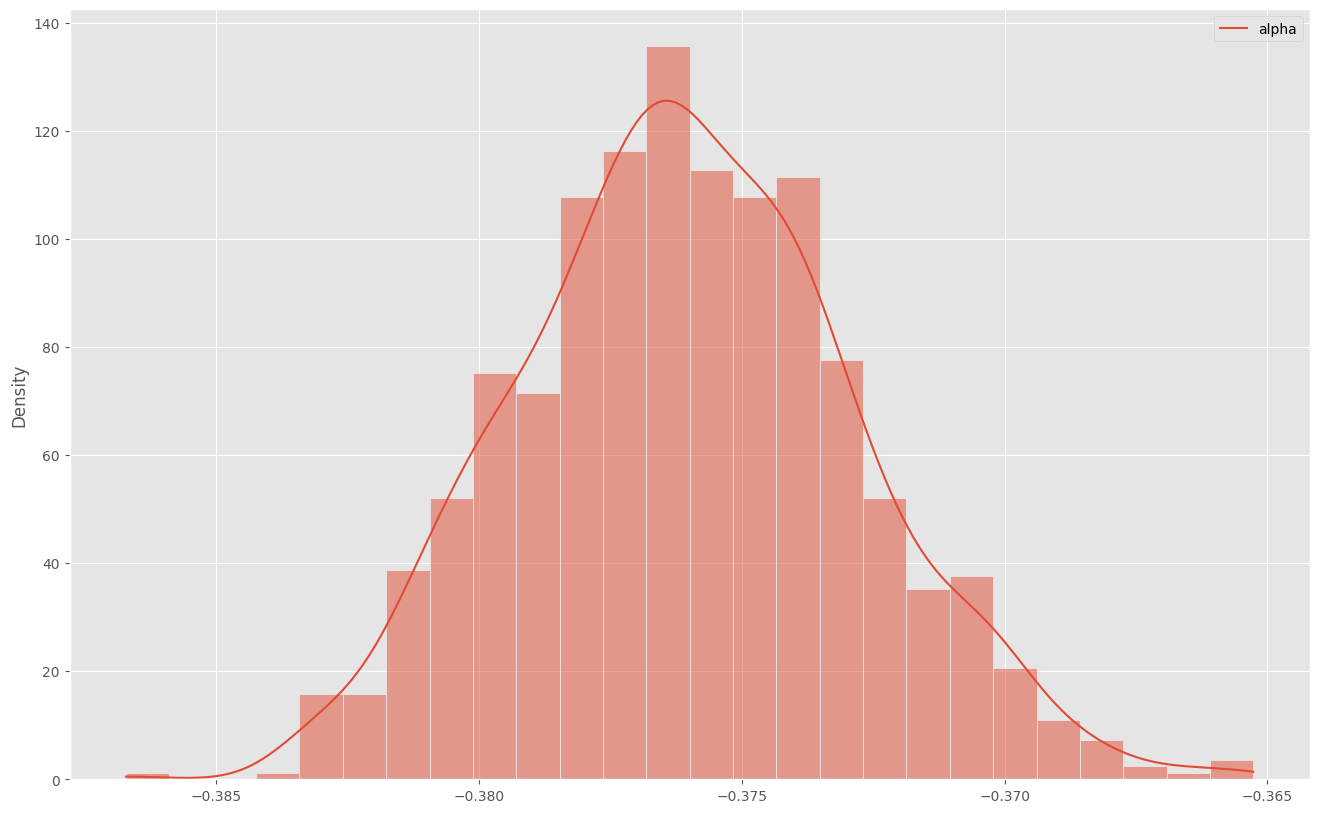

In [36]:
sns.histplot(posterior_samples["alpha"], kde=True, stat="density")

plt.legend(["alpha"])
plt.show()

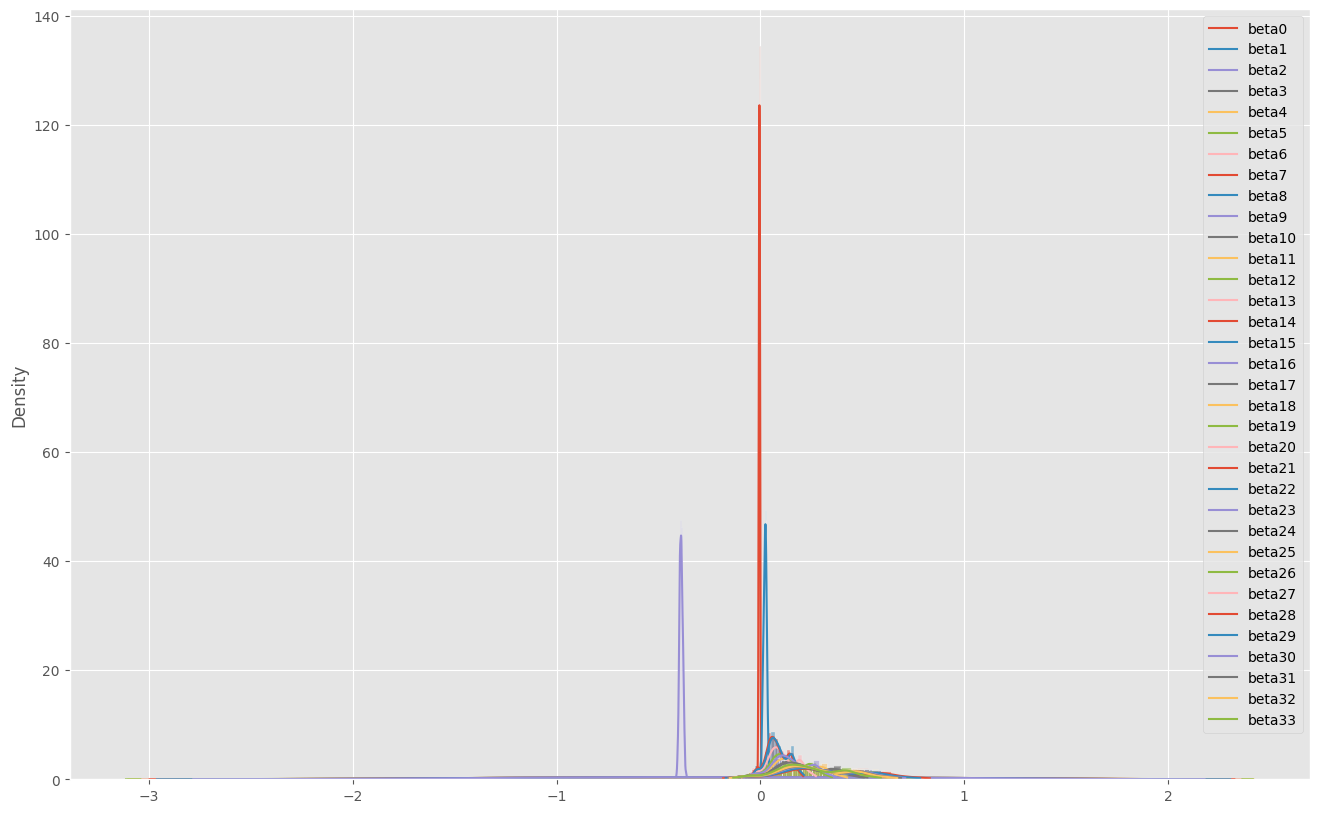

In [37]:
for i in range(X.shape[1]):
    sns.histplot(posterior_samples["beta"][:,i], kde=True, stat="density")
plt.legend(["beta%d" % i for i in range(X.shape[1])])
plt.show()

# Predictions

In [38]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [39]:
y_hat_small = np.mean(np.exp(alpha_samples.T + np.dot(X_test_small, beta_samples.T)), axis=1)

# Convert back to the original scale
preds_small = y_hat_small * y_std
y_true_small = y_test_small * y_std

corr, mae, rae, rmse, r2 = compute_error(y_true_small, preds_small)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: -0.702
MAE: 1.698
RMSE: 2.513
R2: 0.000


# Visualization of results

In [40]:
# To visualize the result we are gonna do it with the following:
# 1. Histrogram
# 2. Residual plot
# 3. Time plot
# 4. Scatterplot

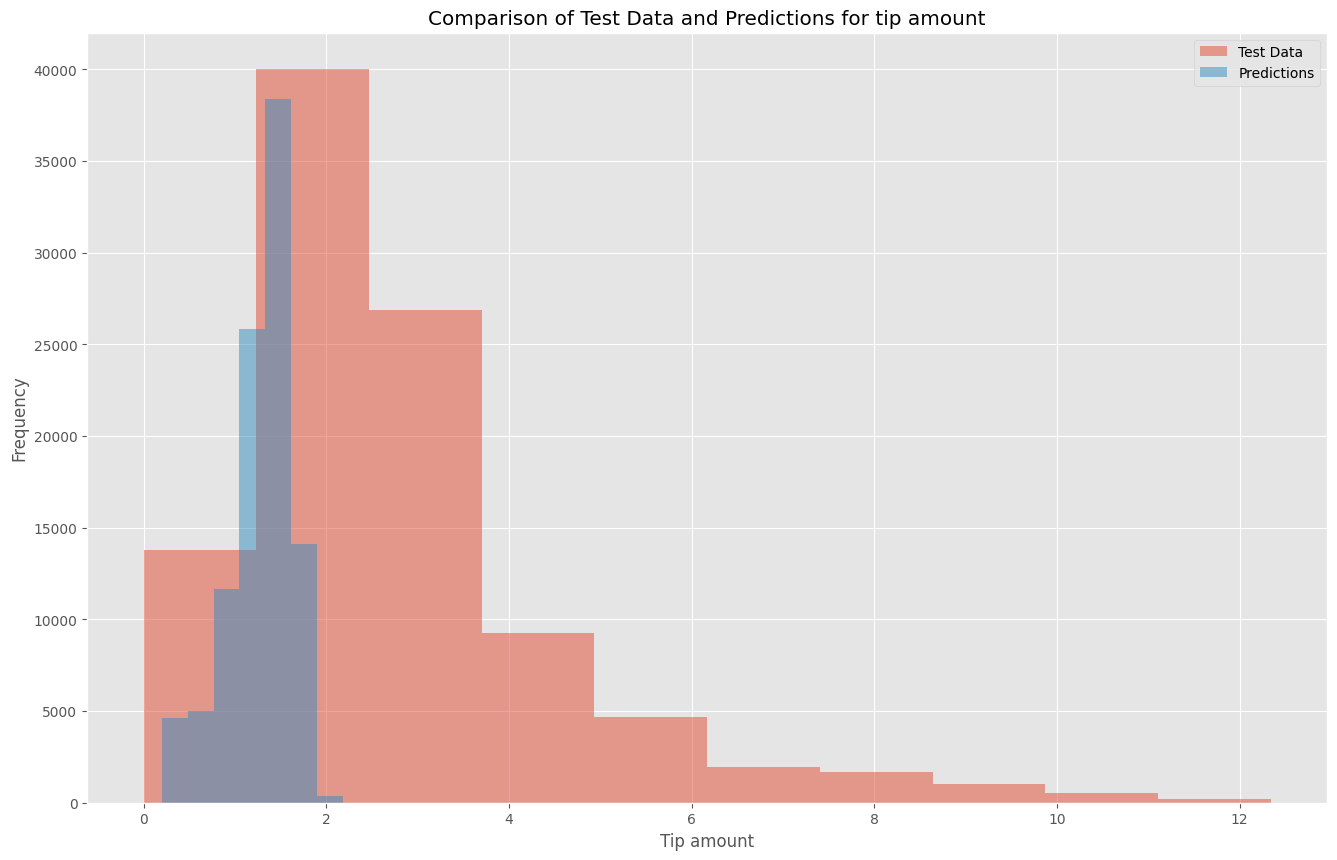

In [41]:
# Generate a histogram
plt.hist(y_true_small, alpha=0.5, label='Test Data')
plt.hist(preds_small, alpha=0.5, label='Predictions')

# Add labels and title to the plot
plt.xlabel('Tip amount')
plt.ylabel('Frequency')
plt.title('Comparison of Test Data and Predictions for tip amount')

# Add legend
plt.legend()

Text(0.5, 1.0, 'Residual Plot: Test Data vs. Predictions')

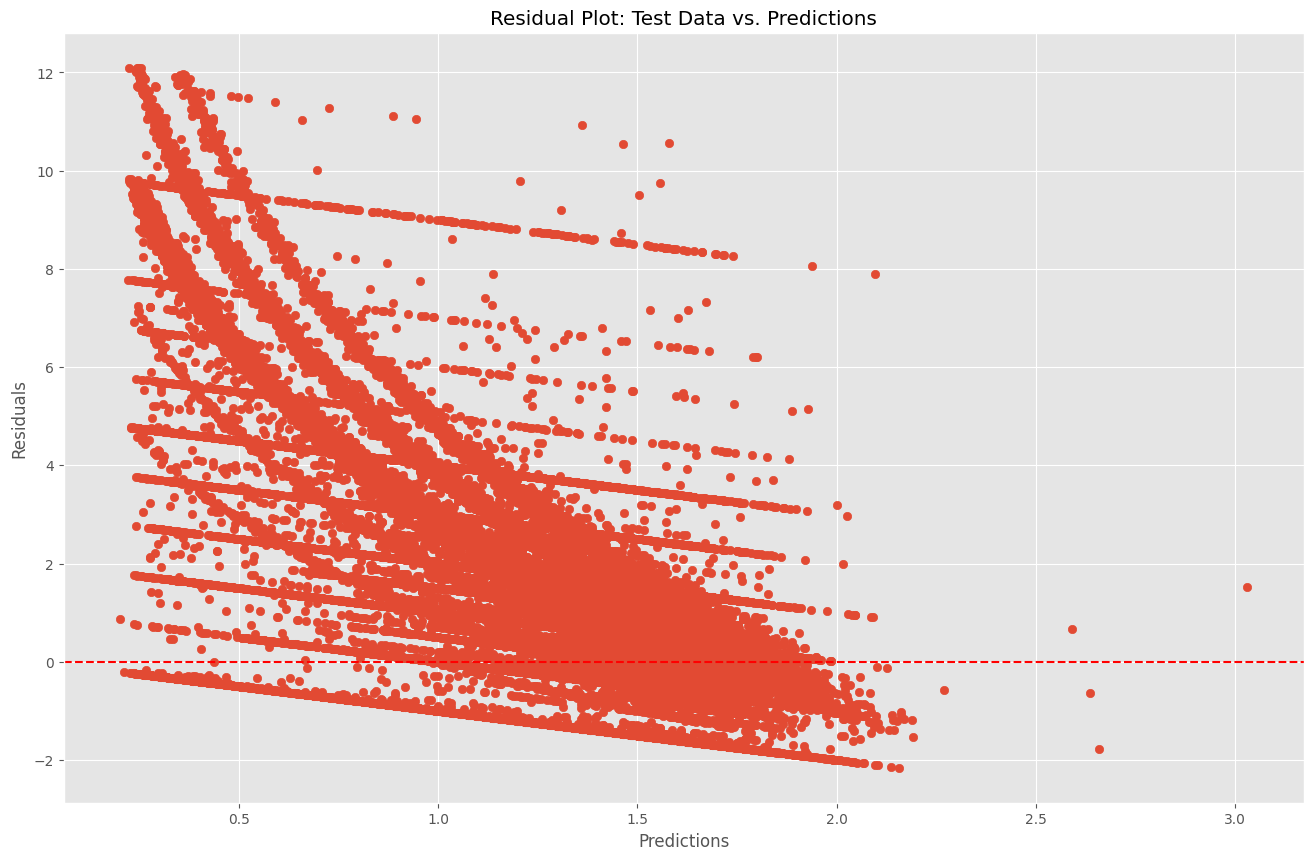

In [42]:
# Generate a residuals plot

# First thing, calculating the residuals
residuals = y_true_small - preds_small

# Then create a scatter plot of residuals vs predictions
plt.scatter(preds_small, residuals)

# Add a horizontal line at y = 0 --> indicate zero residuals
plt.axhline(y=0, color='r', linestyle='--')

# Add labels and title to the plot
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residual Plot: Test Data vs. Predictions')

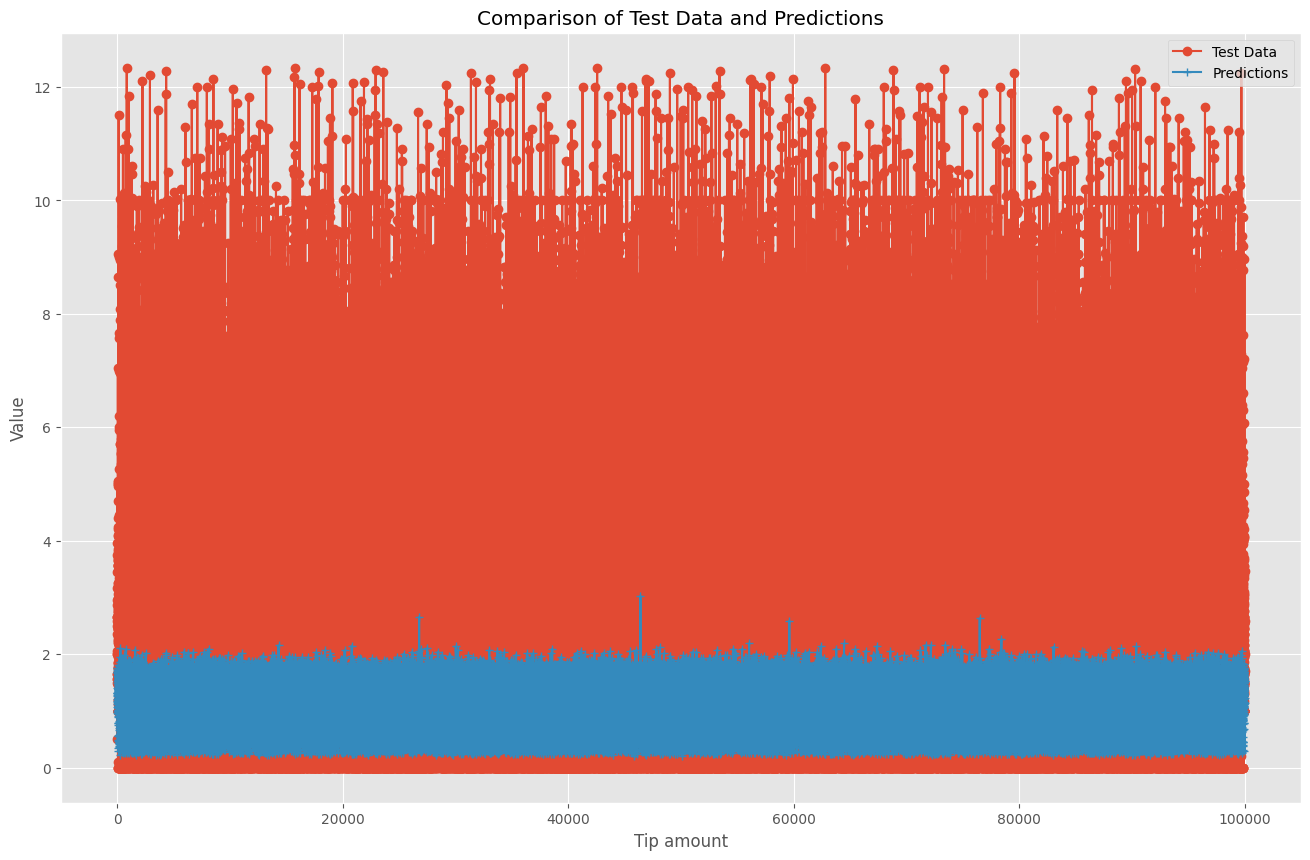

In [45]:
# Generate a line plot

# First, create x-axis values based on the length of the data
x_values = range(1, len(y_true_small) + 1)

# The the actual plot is created
plt.plot(x_values, y_true_small, marker='o', label='Test Data')
plt.plot(x_values, preds_small, marker='+', label='Predictions')

# Add labels and title to the plot
plt.xlabel('Tip amount')
plt.ylabel('Value')
plt.title('Comparison of Test Data and Predictions')

# Add a legend
plt.legend()

Text(0.5, 1.0, 'Scatter Plot: Test Data vs. Predictions')

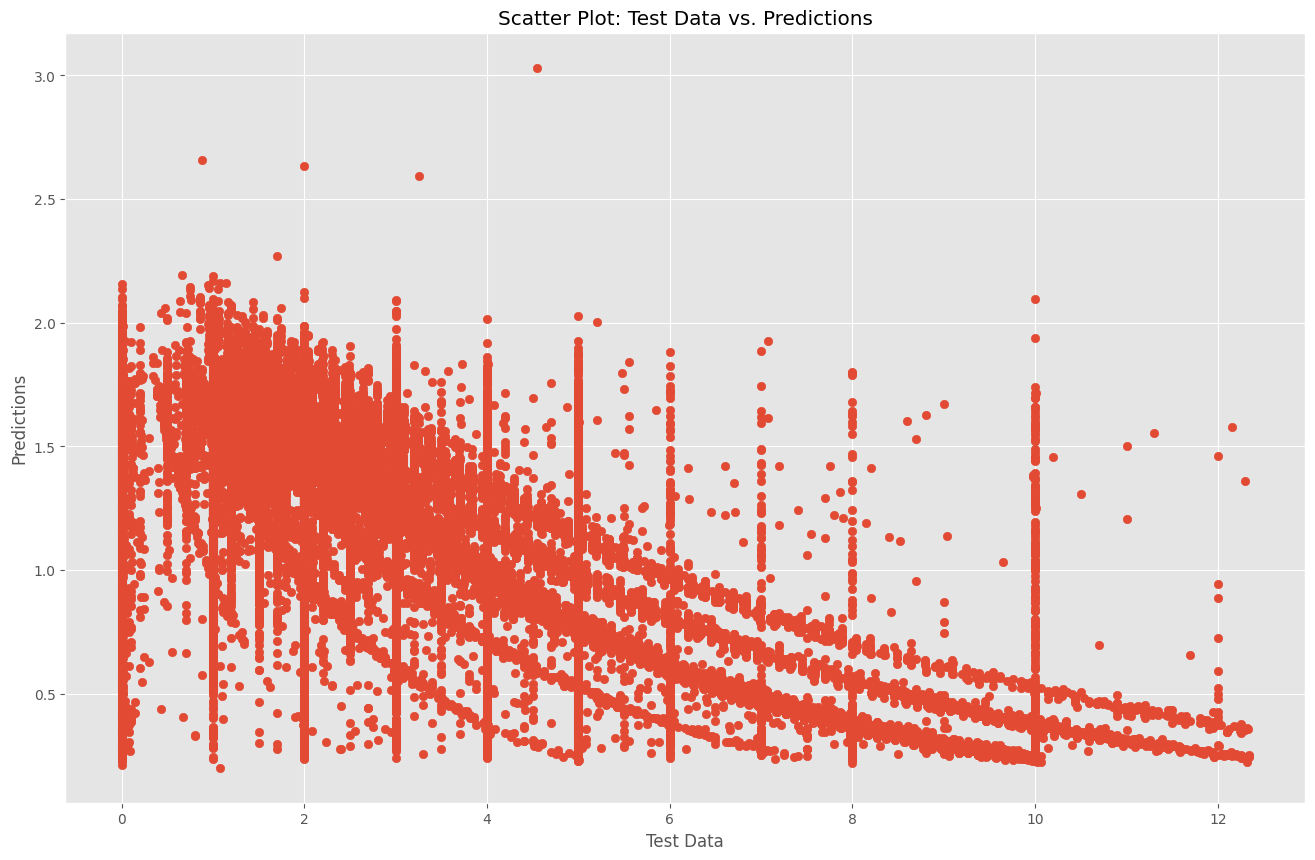

In [44]:
# Generate a scatter plot

# Just take the values directly and set them up against each other
plt.scatter(y_true_small, preds_small)

# Add labels and title to the plot
plt.xlabel('Test Data')
plt.ylabel('Predictions')
plt.title('Scatter Plot: Test Data vs. Predictions')